In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append('../../util')

from curvature import *

In [2]:
#Import simulation
path = '/project/s916/davidle/RCE-MIP/simulations/RCE_300_3km_206x206/' #Path for Daint

In [3]:
#Read Data
#d2D = xr.open_mfdataset(path+'output/lfff????????.nc', combine='by_coords')
d2D = xr.open_mfdataset(path+'output/lfff9?00????.nc', combine='by_coords')

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [4]:
#Mask of all moist regions
bFMSE = np.where(d2D.FMSE > np.median(d2D.FMSE, axis=(1,2))[:, np.newaxis, np.newaxis], 1, 0)

/apps/daint/UES/jenkins/6.0.UP07/gpu/easybuild/software/jupyter/1.0.0-CrayGNU-18.08/lib/python3.6/site-packages/ipykernel_launcher.py:26: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


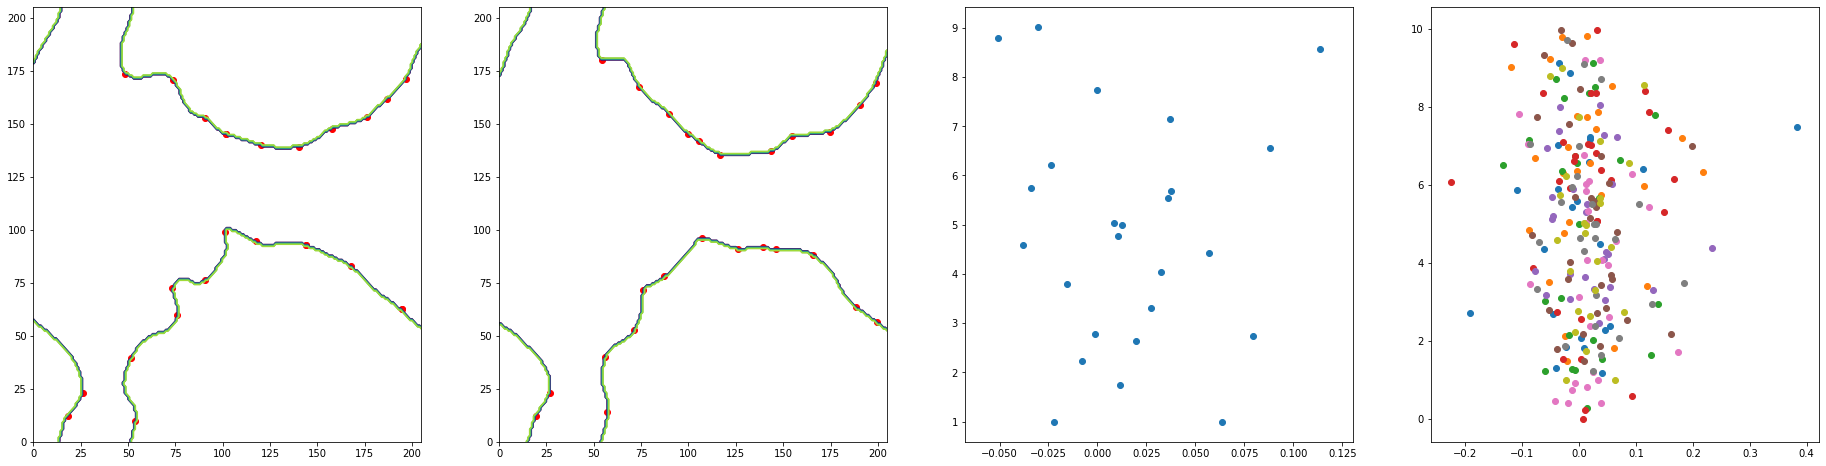

In [6]:
curvature, x, y, x_old, y_old, distance,  = distance_contour_extremas(bFMSE[-1,:,:], bFMSE[-2,:,:])


fig = plt.figure(figsize=(32,8))

plt.subplot(1, 4, 1)
plt.contour(bFMSE[-2,:,:])
plt.scatter(x_old,y_old, c = 'r')

#for en, extrem in enumerate(curvature):
#    circle = plt.Circle((x[en], y[en]), radius = 100 * curvature, facecolor='none', edgecolor='k')
#    ax.add_patch(circle)

plt.subplot(1, 4, 2)
plt.contour(bFMSE[-1,:,:])
plt.scatter(x, y, c = 'r')

plt.subplot(1, 4, 3)
plt.scatter( curvature, distance)

    
plt.subplot(1, 4, 4)
for t in range(1,len(bFMSE)):
    curvature, x, y, x_old, y_old, distance,  = distance_contour_extremas(bFMSE[t,:,:], bFMSE[t-1,:,:])
    
    plt.subplot(1, 4, 4)
    plt.scatter(curvature, distance)
   


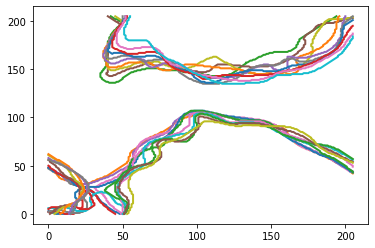

In [7]:
for t in range(len(bFMSE)):
    
    contours = get_contours(bFMSE[t,:,:])
    
    for n, contour in enumerate(contours):
         plt.plot(contour[:, 1], contour[:, 0], linewidth=2)

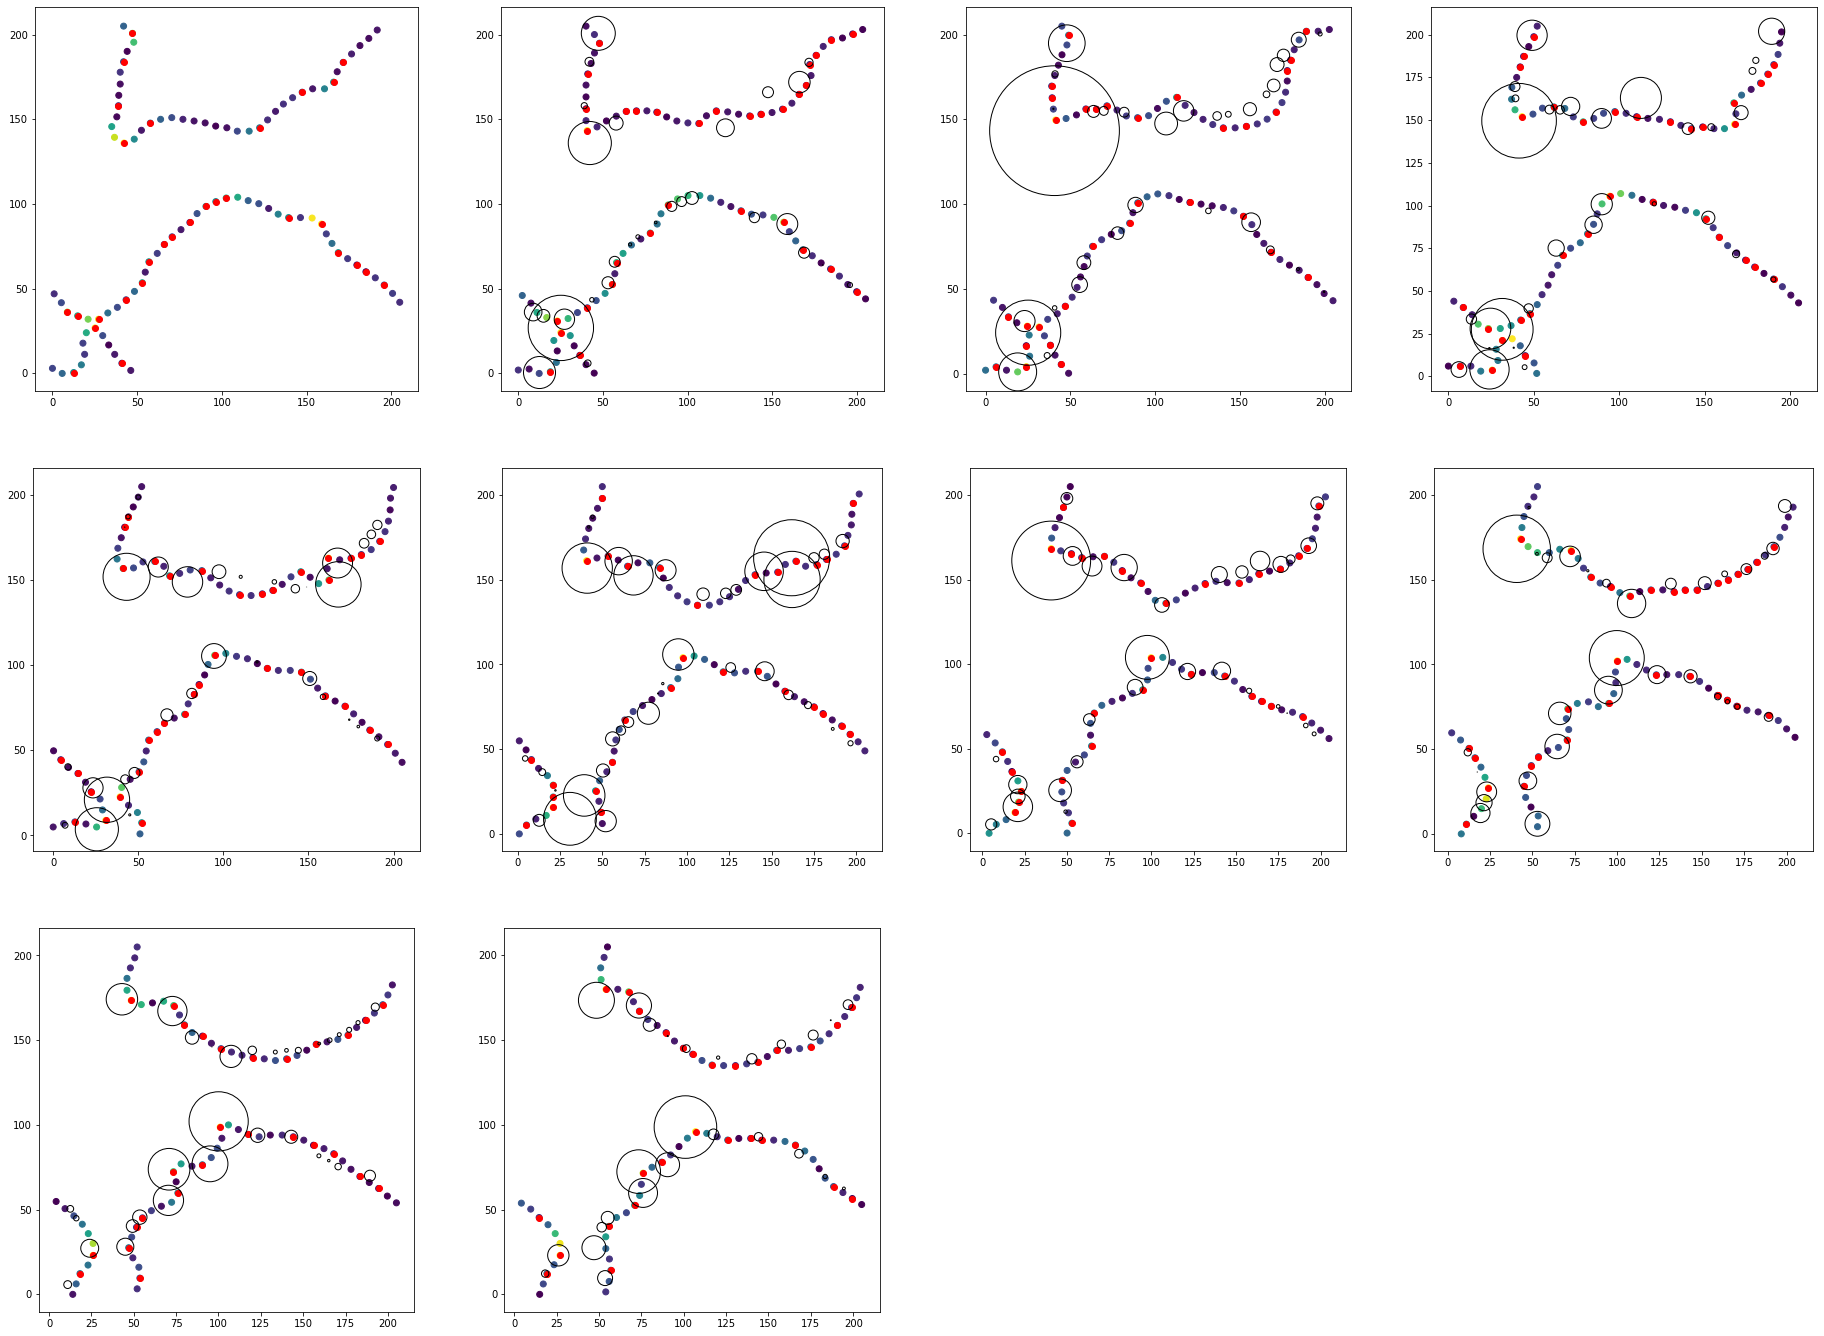

In [11]:
### Plot curvature and local extrema for all contours

fig = plt.figure(figsize=(32,24))
for t in range(len(bFMSE)):
    ax = fig.add_subplot(3,4,t+1)
    ax.set_aspect('equal')

    contours = get_contours(bFMSE[t,:,:])
    contours_last = get_contours(bFMSE[t-1,:,:])

    for n, contour in enumerate(contours):

        #Compute curvature
        x = contour[:, 1]
        y = contour[:, 0]
        xn, yn, curv= calc_curv(x, y)

        #Plot curvature
        ax.scatter(xn, yn, c = np.abs(curv))
    
        #Plot Extrema
        extrema, ex, ey = get_extrema(curv, xn, yn) #Todo: replace by x ,y
        ax.scatter(ex, ey, c = 'r')
    
    #Add circles of extremas of last timestep
    if t > 0:
        for n, contour in enumerate(contours_last):
            cx, cy, curv = calc_curv(contour[:, 1], contour[:, 0])
            extrema, ex, ey= get_extrema(curv, cx, cy)
                
            for en, extrem in enumerate(extrema):
                circle = plt.Circle((ex[en], ey[en]), radius = 100 * extrem, facecolor='none', edgecolor='k')
                ax.add_patch(circle)
              